In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report


In [31]:
df = pd.read_csv('ibm_cleaned.csv')
df.columns.tolist()

['project_building_identifier',
 'project_school_name',
 'project_type',
 'project_description',
 'project_phase_name',
 'project_phase_actual_start_date',
 'project_phase_planned_end_date',
 'project_budget_amount',
 'final_estimate_of_actual_costs_through_end_of_phase_amount',
 'total_phase_actual_spending_amount',
 'dsf_number_s',
 'failure',
 'borough',
 'over_budget_percentage',
 'over_budget_amount',
 'start_and_planned_end_diff']

In [32]:
df = df[[
    'project_type', 'project_phase_name', 'project_budget_amount', 
    'total_phase_actual_spending_amount', 'failure', 
    'borough', 'over_budget_amount',
    'start_and_planned_end_diff'
]]
df.fillna(0, inplace=True)

In [33]:
# Identify non-numeric columns
non_numeric_cols = df.select_dtypes(include=['object']).columns

# Convert non-numeric columns to numeric using one-hot encoding
df = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)
df.replace({True: 1, False: 0}, inplace=True)

/var/folders/l7/rfx8sr1s2h32jhyxdrb33h_40000gn/T/ipykernel_51522/2475311416.py:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({True: 1, False: 0}, inplace=True)


In [34]:
X = df.drop('failure', axis=1)
y = df['failure']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
# Initialize SMOTE
smote = SMOTE(random_state=42)

# Fit SMOTE on the training data and resample
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [37]:
# # Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [38]:
# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       477
           1       0.90      0.92      0.91       171

    accuracy                           0.95       648
   macro avg       0.94      0.94      0.94       648
weighted avg       0.95      0.95      0.95       648



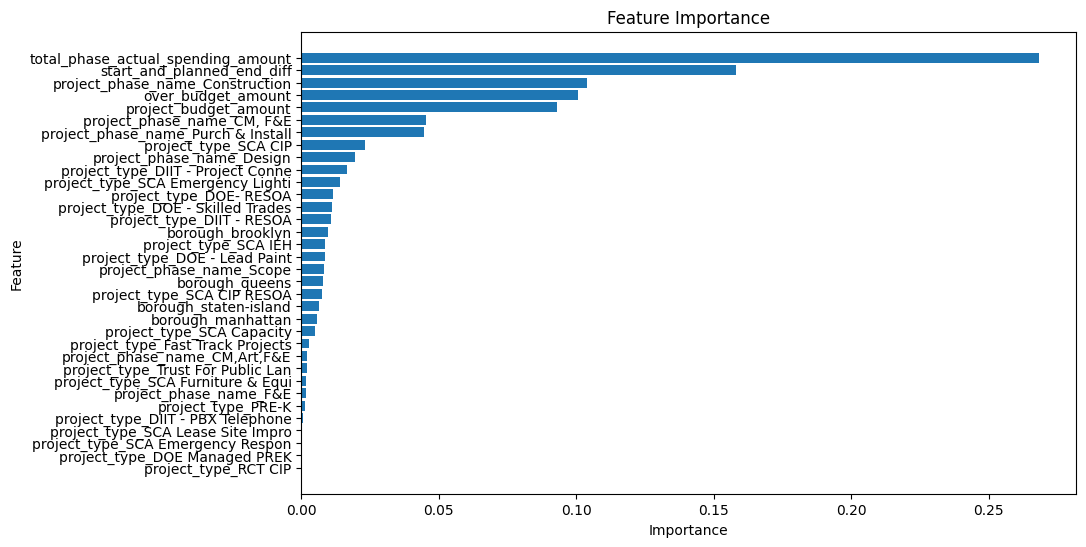

In [39]:
# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()

In [59]:
import shap 
import numpy as np

explainer = shap.Explainer(model, X_train_resampled)

# Compute SHAP values for the test set
shap_values = explainer(X_test)

# Convert the SHAP values object to a list of arrays
shap_values_list = [shap_values[:, :, i].values for i in range(shap_values.values.shape[2])]

# Combine the SHAP values for all classes by summing the absolute values across classes
shap_values_combined = np.sum(np.abs(shap_values_list), axis=0)

In [60]:
rf_exp = shap.TreeExplainer(model)
rf_sv = np.array(rf_exp.shap_values(X_test))
rf_ev = np.array(rf_exp.expected_value)

print("Shape of RF SHAP values:", rf_sv.shape)

Shape of RF SHAP values: (648, 34, 2)


In [61]:
# shap_values_combined

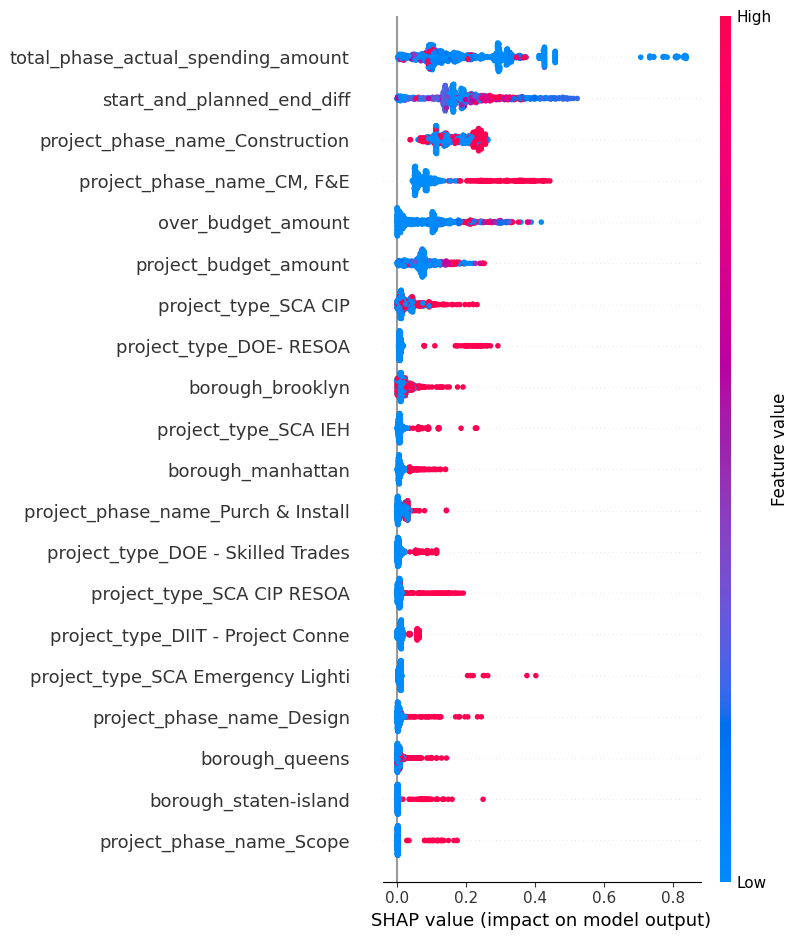

In [62]:
assert shap_values_combined.shape == X_test.shape, "SHAP values and data matrix shapes do not match!"
shap.summary_plot(shap_values_combined, X_test)

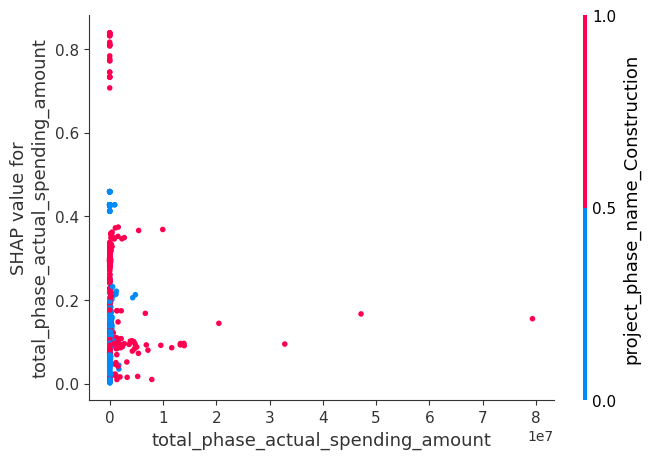

In [52]:
shap.dependence_plot("total_phase_actual_spending_amount", shap_values_combined, X_test, interaction_index="project_phase_name_Construction")